In [2]:
# imports
import math
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

#import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product
from xgboost import XGBClassifier

/usr/local/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [3]:
def cut_eff(x):
    if(x < 12000 or x > 20000):
        return 17000
    else:
        return x
    
def cut_qual(x):
    if(x > 3):
        return 2
    else:
        return x
    
def cut_energy(x):
    if(x < 15 or x > 30):
        return 23
    else:
        return x

# Работа с данными

Объеденим данные по месяцам:

In [4]:
eff_train = pd.read_csv('data/eff_train/eff_train1.csv', sep=';')
for x in range(2,11):
    eff_train_new = pd.read_csv('data/eff_train/eff_train{}.csv'.format(x), sep=';')
    eff_train = pd.concat([eff_train, eff_train_new])
eff_train = eff_train.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_train.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good


In [5]:
eff_test1 = pd.read_csv('data/eff_test/eff_test1.csv', sep=';')
eff_test2 = pd.read_csv('data/eff_test/eff_test2.csv', sep=';')
eff_test = pd.concat([eff_test1, eff_test2])
eff_test = eff_test.rename(columns = {' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
eff_test.head(2)

,tag,timestamp,value,quality
0,Efficiency,01.08.2017 0:00,16836.91,Good
1,Efficiency,01.08.2017 0:00,17145.51,Good


In [6]:
energy_train = pd.read_csv('data/energy_cons_train/Energy_cons_train1.csv', sep=';')
for x in range(2,11):
    energy_train_new = pd.read_csv('data/energy_cons_train/Energy_cons_train{}.csv'.format(x), sep=';')
    energy_train = pd.concat([energy_train, energy_train_new])
energy_train = energy_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_train.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.10.2016 0:01,20.347508,Good
1,Energy_cons,01.10.2016 0:02,20.24238,Good


In [7]:
energy_test = pd.read_csv('data/energy_cons_test/Energy_cons_test1.csv', sep=';')
x=2
energy_test_new = pd.read_csv('data/energy_cons_test/Energy_cons_test{}.csv'.format(x), sep=';')
energy_test = pd.concat([energy_test, energy_test_new])
energy_test = energy_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'})
energy_test.head(2)

,tag,timestamp,value,quality
0,Energy_cons,01.08.2017 0:01,17.324733,Good
1,Energy_cons,01.08.2017 0:02,17.46305,Good


In [8]:
qual_train = pd.read_csv('data/qual_train/qual_train1.csv', sep=';') 
for x in range(2,11): 
    qual_train_new = pd.read_csv('data/qual_train/qual_train{}.csv'.format(x), sep=';') 
    qual_train = pd.concat([qual_train, qual_train_new], ignore_index = True) 
qual_train = qual_train.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_train.head(2)

,tag,timestamp,value,quality
0,Quality,01.10.2016 0:38,2.2,Good
1,Quality,01.10.2016 1:02,2.2,Good


In [9]:
qual_test = pd.read_csv('data/qual_test/qual_test1.csv', sep=';') 
x=2 
qual_test_new = pd.read_csv('data/qual_test/qual_test{}.csv'.format(x), sep=';') 
qual_test = pd.concat([qual_test, qual_test_new]) 
qual_test = qual_test.rename(columns = { ' timestamp':'timestamp', ' value':'value', ' quality':'quality'}) 
qual_test.head(2)

,tag,timestamp,value,quality
0,Quality,01.08.2017 0:14,2.2,Good
1,Quality,01.08.2017 0:38,2.2,Good


Объеденим трэйн и тест:

In [10]:
eff_all = pd.concat([eff_train, eff_test])
qual_all = pd.concat([qual_train, qual_test])
energy_all = pd.concat([energy_train, energy_test])

преобразуем колонку timestamp в тип datetime:

In [11]:
eff_all["timestamp"] = pd.to_datetime(eff_all["timestamp"], format = '%d.%m.%Y %H:%M')
qual_all["timestamp"] = pd.to_datetime(qual_all["timestamp"], format = '%d.%m.%Y %H:%M')
energy_all["timestamp"] = pd.to_datetime(energy_all["timestamp"], format = '%d.%m.%Y %H:%M')

In [12]:
eff_all.head(2)

,tag,timestamp,value,quality
0,Efficiency,2016-10-01,16137.70,Good
1,Efficiency,2016-10-01,16060.55,Good


In [13]:
qual_all.head(2)

,tag,timestamp,value,quality
0,Quality,2016-10-01 00:38:00,2.2,Good
1,Quality,2016-10-01 01:02:00,2.2,Good


In [14]:
energy_all.head()

,tag,timestamp,value,quality
0,Energy_cons,2016-10-01 00:01:00,20.347508,Good
1,Energy_cons,2016-10-01 00:02:00,20.24238,Good
2,Energy_cons,2016-10-01 00:03:00,20.208391,Good
3,Energy_cons,2016-10-01 00:04:00,20.239189,Good
4,Energy_cons,2016-10-01 00:05:00,20.262808,Good


Уберем мусор в данных:

In [15]:
energy_all["value"] = pd.to_numeric(energy_all["value"], downcast = 'float', errors='coerse')
energy_all = energy_all[energy_all["value"].notnull()]

In [16]:
energy_all = energy_all[energy_all["quality"] == "Good"]
qual_all = qual_all[qual_all["quality"] == "Good"]
eff_all = eff_all[eff_all["quality"] == "Good"]
eff_all = eff_all[eff_all["value"] > 0.0]
#qual_all = qual_all[qual_all["value"] > 0.0]
#energy_all = energy_all[energy_all["value"] > 0.0]

# Визуализируем данные

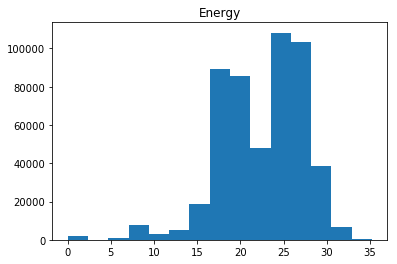

In [18]:
plt.hist(energy_all["value"], 15)
plt.title("Energy")
plt.show()

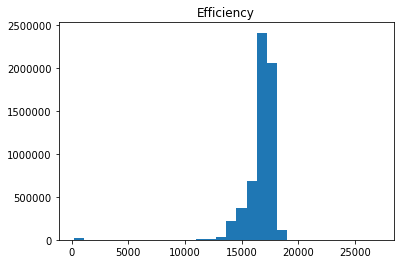

In [19]:
plt.hist(eff_all["value"], 30)
plt.title("Efficiency")
plt.show()

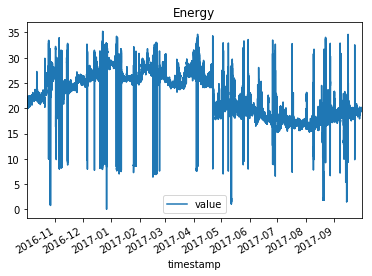

In [20]:
energy_all.plot(x = 'timestamp', y = 'value')
plt.title("Energy")

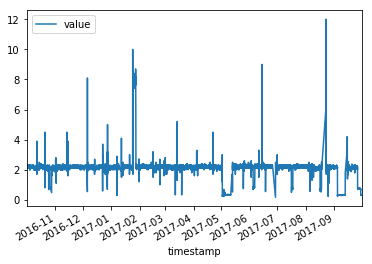

In [21]:
qual_all.plot(x = 'timestamp', y = 'value')

In [4]:
eff_new = pd.DataFrame()
eff_new['timestamp'] = eff_all.groupby("timestamp").value.mean().index
eff_new['value'] = eff_all.groupby("timestamp").value.mean().values
eff_new['day'] = (eff_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

eff_lag_1 = eff_new[eff_new['value'] > 0]
eff_lag_1['value'] = np.array([cut_eff(x) for x in eff_lag_1['value'].values])

eff_lag_1 = eff_lag_1[eff_lag_1['day'] != 364]
#don't use first date
eff_new = eff_new[eff_new['day'] > 0]
eff_new['day'] += -1

mean = eff_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': eff_new['day'].unique()}) 
eff_new = pd.merge(eff_new, df, how = 'left', on = 'day') 
eff_new.head()

NameError: name 'eff_all' is not defined

NameError: name 'eff_new' is not defined

In [26]:
qual_new = pd.DataFrame()
qual_new['timestamp'] = qual_all.groupby("timestamp").value.mean().index
qual_new['value'] = qual_all.groupby("timestamp").value.mean().values
qual_new['day'] = (qual_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

qual_lag_1 = qual_new[qual_new['value'] > 0]
qual_lag_1['value'] = np.array([cut_qual(x) for x in qual_lag_1['value'].values])

qual_lag_1 = qual_lag_1[qual_lag_1['day'] != 364]
#don't use first date
qual_new = qual_new[qual_new['day'] > 0]
qual_new['day'] += -1
mean = qual_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': qual_new['day'].unique()}) 
qual_new = pd.merge(qual_new, df, how = 'left', on = 'day') 
qual_new.head()

,timestamp,value,day,mean_value
0,2016-10-02 00:14:00,2.2,0,2.193443
1,2016-10-02 00:38:00,2.2,0,2.193443
2,2016-10-02 01:02:00,2.2,0,2.193443
3,2016-10-02 01:26:00,2.2,0,2.193443
4,2016-10-02 01:50:00,2.2,0,2.193443


In [28]:
energy_new = pd.DataFrame()
energy_new['timestamp'] = energy_all.groupby("timestamp").value.mean().index
energy_new['value'] = energy_all.groupby("timestamp").value.mean().values
energy_new['day'] = (energy_new['timestamp'].values).astype('datetime64[D]').astype(int)-np.datetime64('2016-10-01').astype('datetime64[D]').astype(int)

energy_lag_1 = energy_new[energy_new['value'] > 0]
energy_lag_1['value'] = np.array([cut_energy(x) for x in energy_lag_1['value'].values])

energy_lag_1 = energy_lag_1[energy_lag_1['day'] != 364]
#don't use first date
energy_new = energy_new[energy_new['day'] > 0]
energy_new['day'] += -1
mean = energy_lag_1.groupby("day").value.mean() 
df = pd.DataFrame({'mean_value': mean, 'day': energy_new['day'].unique()}) 
energy_new = pd.merge(energy_new, df, how = 'left', on = 'day') 
energy_new.head()

/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,timestamp,value,day,mean_value
0,2016-10-02 00:00:00,20.343477,0,20.387334
1,2016-10-02 00:01:00,20.349155,0,20.387334
2,2016-10-02 00:02:00,20.396097,0,20.387334
3,2016-10-02 00:03:00,20.223352,0,20.387334
4,2016-10-02 00:04:00,20.293682,0,20.387334


In [30]:
energy_new['diff'] = energy_new['value'] - energy_new['mean_value']
qual_new['diff'] =  qual_new['value'] - qual_new['mean_value']
eff_new['diff'] = eff_new['value'] - eff_new['mean_value']

In [38]:
D_eff = (eff_new['diff']**2).mean()
#print "Efficiency RMSE = {}".format(math.sqrt(D_eff))
D_qual = (qual_new['diff']**2).mean()
#print "Qual RMSE = {}".format(math.sqrt(D_qual))
D_energy = (energy_new['diff']**2).mean()
#print "Energy RMSE = {}".format(math.sqrt(D_eff))

In [39]:
def cut_norm_eff(x):
    if (math.fabs(x) > 2*math.sqrt(D_eff)):
        return 1
    else:
        return 0

In [40]:
eff_new['probability'] = eff_new['diff'].apply(lambda x: cut_norm_eff(x))

In [41]:
eff_new.tail(2)

,timestamp,value,day,mean_value,diff,probability
492021,2017-09-30 23:59:00,15394.936667,363,16064.760874,-669.824208,0
492022,2017-10-01 00:00:00,15341.800000,364,15341.800000,0.000000,0


In [57]:
eff_train = eff_new[eff_new['day'] < 300]
eff_test = eff_new[eff_new['day'] >= 300]

In [63]:
X_train_eff = eff_train.drop(['timestamp','day','probability'], axis = 1)
X_test_eff = eff_test.drop(['timestamp','day','probability'], axis = 1)
y_train_eff = eff_train['probability'].values.astype(int)
y_test_eff = eff_test['probability'].values.astype(int)

(array([ 401358.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,    8801.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

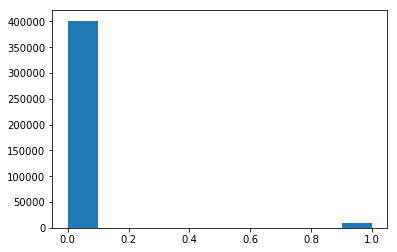

In [60]:
plt.hist(y_train_eff)

In [86]:
model = XGBClassifier()
model_fit = model.fit(X_train_eff, y_train_eff)
preds_validation = model_fit.predict(X_test_eff)

In [88]:
model_fit.evals_result

<bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [78]:
print((1 - ((preds_validation-y_test_eff)**2).sum()/(((y_test_eff-y_test_eff.mean())**2).sum())))

1.0


In [83]:
preds_eff = pd.DataFrame(data = eff_test) 
preds_eff['probability'] = preds_validation
preds_eff.head()

,timestamp,value,day,mean_value,diff,probability
410159,2017-07-29 00:00:00,17420.167500,300,17311.449795,108.717705,0
410160,2017-07-29 00:01:00,17395.100833,300,17311.449795,83.651038,0
410161,2017-07-29 00:02:00,17348.063333,300,17311.449795,36.613538,0
410162,2017-07-29 00:03:00,17440.430833,300,17311.449795,128.981038,0
410163,2017-07-29 00:04:00,17414.469167,300,17311.449795,103.019372,0


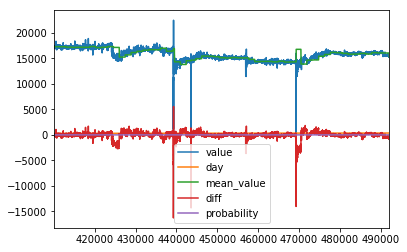

In [89]:
preds_eff.plot()